# Pentapeptide showcase with PyEMMA

This notebook now mirrors the **00 - Showcase pentapeptide** walkthrough from the [PyEMMA Learn portal](http://www.emma-project.org/devel/generated/00-pentapeptide-showcase.html). We keep the steps minimal, load the official mdshare dataset, compare backbone featurizations with VAMP2, project into TICA, cluster the slow degrees of freedom, estimate and validate MSMs, visualize MSM spectra, and inspect PCCA/TPT results together with simple experimental observables. All data references follow the `COURSE_DIR/data` convention used across the course. 


## Table of contents

- [Step 1](#step-1)
- [Data input and featurization](#data-input-and-featurization)
- [Step 3](#step-3)
- [Feature ranking with VAMP2](#feature-ranking-with-vamp2)
- [Coordinate transform: TICA](#coordinate-transform-tica)
- [Discretization via clustering](#discretization-via-clustering)
- [MSM estimation & validation](#msm-estimation-validation)
- [Step 8](#step-8)
- [Spectral analysis & PCCA/TPT](#spectral-analysis-pccatpt)
- [Step 10](#step-10)
- [Experimental observables and PCCA samples](#experimental-observables-and-pcca-samples)


## Step 1


In [2]:
from pathlib import Path
import os

from contextlib import nullcontext
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import mdshare
import pyemma

COURSE_DIR = Path(os.environ.get('COURSE_DIR', str(Path.home() / 'Concepcion26'))).expanduser()
DATA_DIR = COURSE_DIR / 'data'
DATA_DIR.mkdir(parents=True, exist_ok=True)

/home/jordivilla/miniconda3/envs/pyemma/lib/python3.9/site-packages/mdshare/__init__.py:24: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound


## Data input and featurization

The tutorial loads a pentapeptide PDB and 25 trajectories (implicit solvent, 0.1 ns timestep) via `mdshare.fetch` and compares several backbone featurizations. We mimic that flow here.


In [3]:
pdb = mdshare.fetch('pentapeptide-impl-solv.pdb', working_directory=str(DATA_DIR))
files = mdshare.fetch('pentapeptide-*-500ns-impl-solv.xtc', working_directory=str(DATA_DIR))
print('Topology:', pdb)
print('Trajectories:', len(files))

Topology: /home/jordivilla/Concepcion26/data/pentapeptide-impl-solv.pdb
Trajectories: 25


## Step 3


In [4]:
torsions_feat = pyemma.coordinates.featurizer(str(pdb))
torsions_feat.add_backbone_torsions(cossin=True, periodic=False)
torsions_data = pyemma.coordinates.load(files, features=torsions_feat)

positions_feat = pyemma.coordinates.featurizer(str(pdb))
positions_feat.add_selection(positions_feat.select_Backbone())
positions_data = pyemma.coordinates.load(files, features=positions_feat)

backbone = torsions_feat.select_Backbone()
distances_feat = pyemma.coordinates.featurizer(str(pdb))
distances_feat.add_distances(distances_feat.pairs(backbone, excluded_neighbors=2), periodic=False)
distances_data = pyemma.coordinates.load(files, features=distances_feat)


100%|██████████| 25/25 [00:00<00:00, 36.61it/s]                                 


## Feature ranking with VAMP2

We compute cross-validated VAMP2 scores for the torsions, position, and distance featurizations at several lag times to identify the most kinetically informative descriptors.


/home/jordivilla/miniconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:235: PyEMMA_DeprecationWarning: Call to deprecated function "vamp". Called from /home/jordivilla/miniconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 235. Use deeptime.decomposition.VAMP instead.
  return caller(func, *(extras + args), **kw)
100%|██████████| 12/12 [00:00<00:00, 1092.93it/s]            
/home/jordivilla/miniconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:235: PyEMMA_DeprecationWarning: Call to deprecated function "vamp". Called from /home/jordivilla/miniconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 235. Use deeptime.decomposition.VAMP instead.
  return caller(func, *(extras + args), **kw)
100%|██████████| 12/12 [00:00<00:00, 992.85it/s]             
/home/jordivilla/miniconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:235: PyEMMA_DeprecationWarning: Call to deprecated function "vamp". Called from /home/jordivilla/miniconda3/envs/pyem

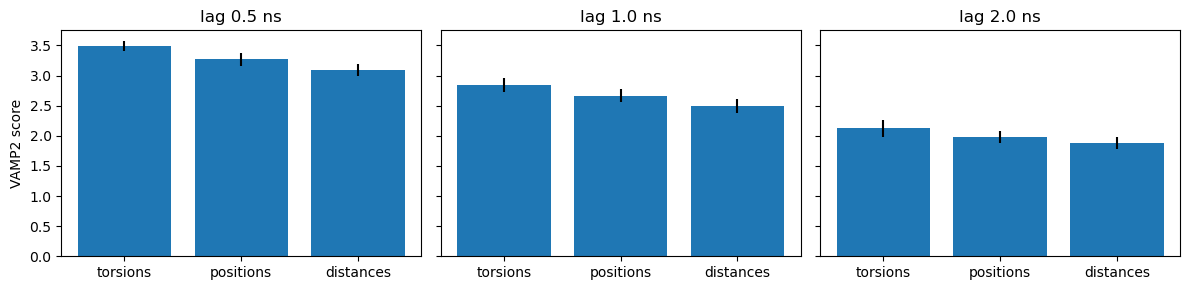

In [5]:
def score_cv(data, dim, lag, number_of_splits=10, validation_fraction=0.5):
    contexts = getattr(pyemma.util, 'contexts', None)
    if contexts is None:
        ctx = nullcontext()
    else:
        ctx = contexts.settings(show_progress_bars=False)
    with ctx:
        nval = int(len(data) * validation_fraction)
        scores = np.zeros(number_of_splits)
        for n in range(number_of_splits):
            ival = np.random.choice(len(data), size=nval, replace=False)
            vamp = pyemma.coordinates.vamp([
                d for i, d in enumerate(data) if i not in ival], lag=lag, dim=dim)
            scores[n] = vamp.score([d for i, d in enumerate(data) if i in ival])
    return scores

labels = ['torsions', 'positions', 'distances']

fig, axes = plt.subplots(1, 3, figsize=(12, 3), sharey=True)
for ax, lag in zip(axes.flat, [5, 10, 20]):
    data_scores = []
    data_errors = []
    for dataset in (torsions_data, positions_data, distances_data):
        sc = score_cv(dataset, dim=10, lag=lag)
        data_scores.append(sc.mean())
        data_errors.append(sc.std())
    ax.bar(labels, data_scores, yerr=data_errors)
    ax.set_title(f'lag {lag * 0.1:.1f} ns')
axes[0].set_ylabel('VAMP2 score')
fig.tight_layout()

VAMP2 revealed backbone torsions as slightly superior, so we continue with those coordinates.


## Coordinate transform: TICA


/home/jordivilla/miniconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:235: PyEMMA_DeprecationWarning: Call to deprecated function "tica". Called from /home/jordivilla/miniconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 235. Use deeptime.decomposition.TICA instead.
  return caller(func, *(extras + args), **kw)
100%|██████████| 25/25 [00:00<00:00, 1593.65it/s]             


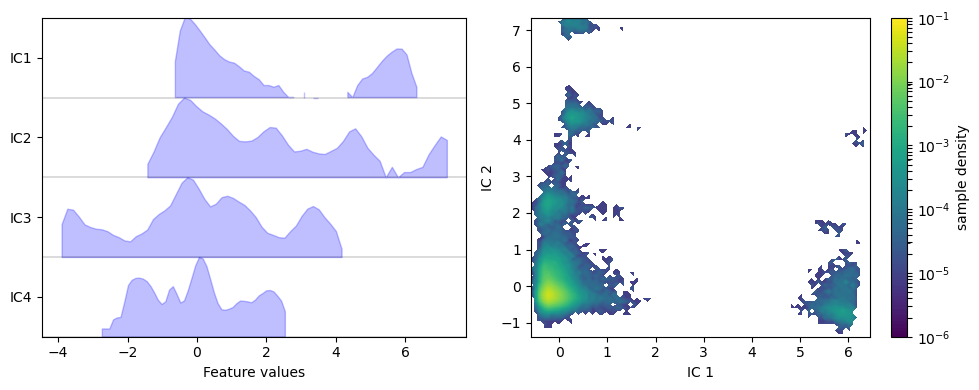

In [6]:
tica = pyemma.coordinates.tica(torsions_data, lag=5)
tica_output = tica.get_output()
tica_concatenated = np.concatenate(tica_output)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
pyemma.plots.plot_feature_histograms(tica_concatenated, ax=axes[0], feature_labels=[f'IC{i+1}' for i in range(4)], ylog=True)
pyemma.plots.plot_density(*tica_concatenated[:, :2].T, ax=axes[1], logscale=True)
axes[1].set_xlabel('IC 1')
axes[1].set_ylabel('IC 2')
fig.tight_layout()

## Discretization via clustering


/home/jordivilla/miniconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py:235: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /home/jordivilla/miniconda3/envs/pyemma/lib/python3.9/site-packages/decorator.py line 235. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
100%|██████████| 50/50 [00:00<00:00, 203.90it/s]
/home/jordivilla/miniconda3/envs/pyemma/lib/python3.9/site-packages/numpy/core/numeric.py:330: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')
100%|██████████| 25/25 [00:00<00:00, 4097.60it/s]                         
/tmp/ipykernel_15781/1125788638.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  scores[idx, trial] = msm.score_cv(cl.dtrajs, n=1, score_method='VAMP

16-01-26 06:35:00 pyemma.coordinates.clustering.kmeans.KmeansClustering[667] WARNING  Algorithm did not reach convergence criterion of 1e-05 in 50 iterations. Consider increasing max_iter.



/home/jordivilla/miniconda3/envs/pyemma/lib/python3.9/site-packages/numpy/core/numeric.py:330: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')
100%|██████████| 25/25 [00:00<00:00, 494.79it/s]                          


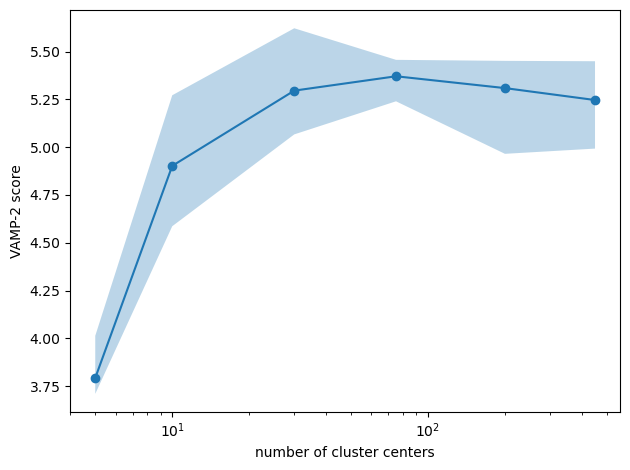

In [7]:
ncenters = [5, 10, 30, 75, 200, 450]
scores = np.zeros((len(ncenters), 5))
contexts = getattr(pyemma.util, 'contexts', None)
for idx, k in enumerate(ncenters):
    for trial in range(5):
        ctx = contexts.settings(show_progress_bars=False) if contexts else nullcontext()
        with ctx:
            cl = pyemma.coordinates.cluster_kmeans(tica_output, k=k, max_iter=50, stride=50)
            msm = pyemma.msm.estimate_markov_model(cl.dtrajs, 5)
            scores[idx, trial] = msm.score_cv(cl.dtrajs, n=1, score_method='VAMP2', score_k=min(10, k))

fig, ax = plt.subplots()
lower, upper = pyemma.util.statistics.confidence_interval(scores.T.tolist(), conf=0.9)
ax.fill_between(ncenters, lower, upper, alpha=0.3)
ax.plot(ncenters, scores.mean(axis=1), '-o')
ax.set_xscale('log')
ax.set_xlabel('number of cluster centers')
ax.set_ylabel('VAMP-2 score')
fig.tight_layout()

k = 75
cluster = pyemma.coordinates.cluster_kmeans(tica_output, k=k, max_iter=50, stride=10, fixed_seed=1)
dtrajs = np.concatenate(cluster.dtrajs)


## MSM estimation & validation


In [ ]:
msm = pyemma.msm.bayesian_markov_model(cluster.dtrajs, lag=5, dt_traj='0.1 ns')
print('fraction of states used:', msm.active_state_fraction)
print('fraction of counts used:', msm.active_count_fraction)
its = pyemma.msm.its(cluster.dtrajs, lags=50, nits=15, errors='bayes')
pyemma.plots.plot_implied_timescales(its, units='ns', dt=0.1)


100%|██████████| 100/100 [00:00<00:00, 222.87it/s]                                                                   


fraction of states used: 1.0
fraction of counts used: 1.0


estimating BayesianMSM:  90%|█████████ | 9/10 [00:09<00:00,  1.66it/s]

## Step 8


In [ ]:
nstates = 5
cktest = msm.cktest(nstates, mlags=6)
pyemma.plots.plot_cktest(cktest, dt=0.1, units='ns')

## Spectral analysis & PCCA/TPT


In [ ]:
eigvec = msm.eigenvectors_right()
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
pyemma.plots.plot_contour(*tica_concatenated[:, :2].T, eigvec[dtrajs, 1], ax=axes[0], cmap='PiYG', mask=True)
pyemma.plots.plot_contour(*tica_concatenated[:, :2].T, eigvec[dtrajs, 2], ax=axes[1], cmap='PiYG', mask=True)
[ax.set_xlabel('IC 1') for ax in axes];
axes[0].set_ylabel('IC 2')

## Step 10


In [ ]:
pcca = msm.pcca(nstates)
metatraj = msm.metastable_assignments[dtrajs]
fig, ax = plt.subplots(figsize=(4, 4))
pyemma.plots.plot_state_map(*tica_concatenated[:, :2].T, metatraj, ax=ax)
ax.set_xlabel('IC 1')
ax.set_ylabel('IC 2')


## Experimental observables and PCCA samples


In [ ]:
from itertools import product
from mdtraj import shrake_rupley, compute_rg

markov_samples = [smpl for smpl in msm.sample_by_state(20)]
reader = pyemma.coordinates.source(files, top=str(pdb))
samples = [pyemma.coordinates.save_traj(reader, sample, outfile=None, top=str(pdb)) for sample in markov_samples]
markov_sasa = [shrake_rupley(sample, mode='residue') for sample in samples]
markov_rg = [compute_rg(sample) for sample in samples]
markov_average_rg = np.array(markov_rg).mean(axis=1)
print('Average Rg (nm):', msm.expectation(markov_average_rg))

To finish, follow the remaining PyEMMA notebooks if you want deeper practice with MSM analysis, PCCA/TPT, and HMMs, just like the original showcase links do.
